In [3]:
pip install selenium beautifulsoup4 pandas matplotlib seaborn openpyxl

You should consider upgrading via the 'C:\Users\ashridha\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [40]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time
import pandas as pd

# Setup headless Chrome
options = Options()
options.add_argument("--headless")
driver = webdriver.Chrome(options=options)

# Open Amazon search
search_term = "soft toys"
url = f"https://www.amazon.in/s?k={search_term.replace(' ', '+')}"
driver.get(url)

# Wait for content to load
WebDriverWait(driver, 15).until(
    EC.presence_of_element_located((By.CSS_SELECTOR, "div.s-main-slot"))
)
time.sleep(3)

# Parse HTML
soup = BeautifulSoup(driver.page_source, 'html.parser')
products = soup.find_all('div', {'data-component-type': 's-search-result'})
print("Total results found:", len(products))

data = []

for i, product in enumerate(products):
    try:
        # Check for Sponsored label
        sponsored_tag = product.find('span', string="Sponsored")
        if sponsored_tag:
            continue

        # Get ASIN and construct product URL
        asin = product.get('data-asin')
        product_url = f"https://www.amazon.in/dp/{asin}" if asin else None

         # TITLE
        h2_tag = product.find('h2')
        title_tag = h2_tag.find('span') if h2_tag else None
        title = title_tag.text.strip() if title_tag else "No Title"

        # BRAND (Try multiple ways to extract)
        # Try to get brand from data-attribute
        brand = product.get('data-brand')

        # Fallback: Look inside a specific block
        if not brand:
            brand_span = product.select_one("div.a-row.a-size-base.a-color-secondary span")
            if brand_span and not any(char.isdigit() for char in brand_span.text.strip()):
                brand = brand_span.text.strip()

        # Last fallback: First word of title
        if not brand and title:
            brand = title.split()[0]

        # Final fallback
        if not brand:
            brand = "Unknown"

        # Rating
        rating_tag = product.find('span', class_='a-icon-alt')
        rating = float(rating_tag.text.split()[0]) if rating_tag else None

        # Reviews
        review_tag = product.find('span', {'class': 'a-size-base'})
        reviews = int(review_tag.text.replace(",", "")) if review_tag and review_tag.text.replace(",", "").isdigit() else 0

        # Price
        price_tag = product.find('span', class_='a-price-whole')
        price = int(price_tag.text.replace(",", "").replace("₹", "")) if price_tag else None

        # Image
        image_tag = product.find('img')
        image_url = image_tag['src'] if image_tag else None

        # Save if all critical info is available
        if product_url and title:
            data.append({
                'Title': title,
                'Brand': brand,
                'Rating': rating,
                'Reviews': reviews,
                'Price': price,
                'Image URL': image_url,
                'Product URL': product_url
            })

    except Exception as e:
        print(f"[{i}] Error parsing product: {e}")
        continue

driver.quit()

# Save to DataFrame
df = pd.DataFrame(data)
print("Sponsored products scraped:", len(df))
df.to_csv("sponsored_soft_toys.csv", index=False)


Total results found: 48
Sponsored products scraped: 48


In [41]:
df = pd.read_csv('sponsored_soft_toys.csv')
print(df.columns.tolist())
df.head()

['Title', 'Brand', 'Rating', 'Reviews', 'Price', 'Image URL', 'Product URL']


,Title,Brand,Rating,Reviews,Price,Image URL,Product URL
0,Storio Toy Octopus Plushie Reversible Soft Toy...,Storio,4.2,1680,179,https://m.media-amazon.com/images/I/51nqXz7iWr...,https://www.amazon.in/dp/B0D6Z1YPTZ
1,Babique Dog Sitting Plush Soft Toy Cute Kids A...,Babique,4.2,2651,169,https://m.media-amazon.com/images/I/51h6wRH0lp...,https://www.amazon.in/dp/B0B2F8XS9L
2,Babique Elephant Sitting Plush Soft Toy Cute K...,Babique,4.2,2650,253,https://m.media-amazon.com/images/I/71sh-Yt3Em...,https://www.amazon.in/dp/B0BD5TR6FD
3,Amazon Brand - Jam & Honey Soft Penguin Plush ...,Amazon,4.4,13332,198,https://m.media-amazon.com/images/I/61A2ddWFQx...,https://www.amazon.in/dp/B0C46HFZX6
4,Babique Unicorn Teddy Bear Plush Soft Toy Cute...,Babique,4.1,4740,169,https://m.media-amazon.com/images/I/51AWNa6+TO...,https://www.amazon.in/dp/B08LTGRJSV


In [42]:
# Load data
df = pd.read_csv('sponsored_soft_toys.csv')

# Remove duplicates
df.drop_duplicates(inplace=True)

# Convert columns
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')
df['Reviews'] = pd.to_numeric(df['Reviews'], errors='coerce')

# Drop rows with missing essential info
df.dropna(subset=['Price', 'Rating', 'Reviews'], inplace=True)

df.to_csv("amazon_soft_toys_clean.csv", index=False)


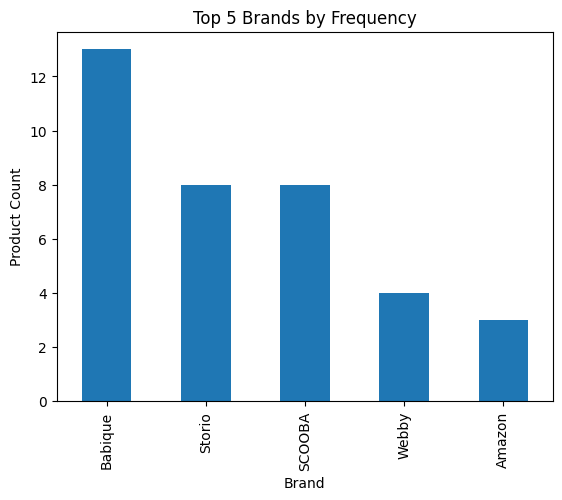

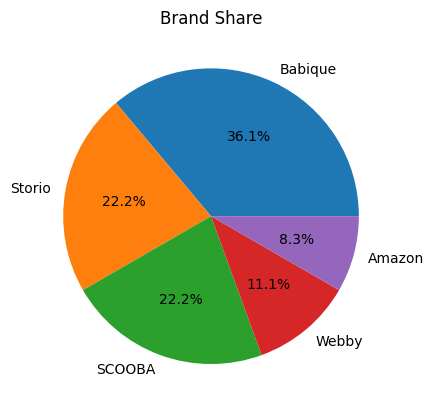

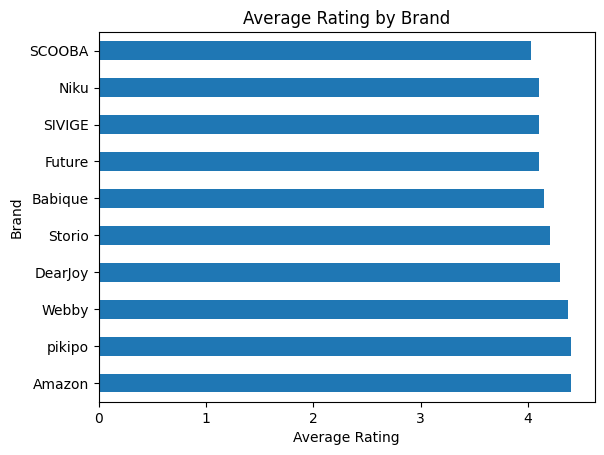

In [43]:
import matplotlib.pyplot as plt
import seaborn as sns

# Top brands by frequency
brand_freq = df['Brand'].value_counts().head(5)
brand_freq.plot(kind='bar', title='Top 5 Brands by Frequency')
plt.ylabel("Product Count")
plt.show()

# Pie chart
brand_freq.plot.pie(autopct='%1.1f%%', title='Brand Share')
plt.ylabel("")
plt.show()

# Avg rating by brand
brand_rating = df.groupby('Brand')['Rating'].mean().sort_values(ascending=False).head(10)
brand_rating.plot(kind='barh', title='Average Rating by Brand')
plt.xlabel("Average Rating")
plt.show()


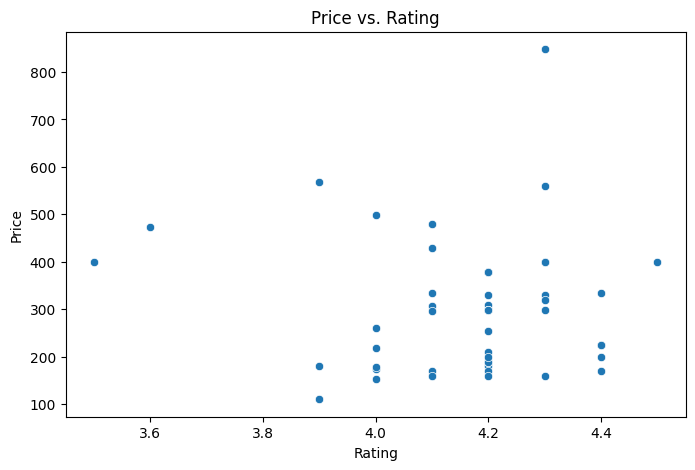

C:\Users\ashridha\AppData\Local\Temp\ipykernel_1080\88562293.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_price = df.groupby('Rating Range')['Price'].mean()


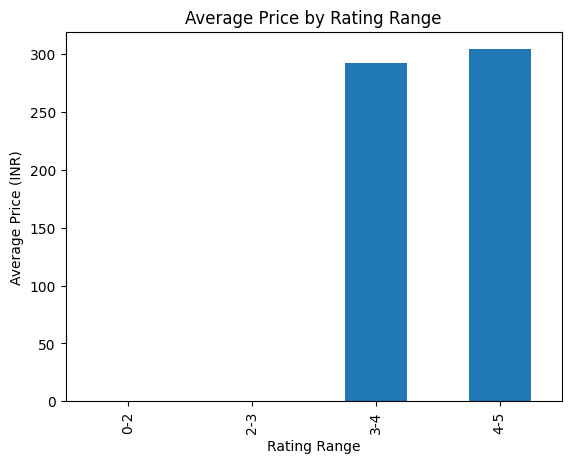

In [44]:
# Scatter plot
plt.figure(figsize=(8,5))
sns.scatterplot(x='Rating', y='Price', data=df)
plt.title('Price vs. Rating')
plt.show()

# Bar chart of average price per rating range
df['Rating Range'] = pd.cut(df['Rating'], bins=[0, 2, 3, 4, 5], labels=['0-2', '2-3', '3-4', '4-5'])
avg_price = df.groupby('Rating Range')['Price'].mean()
avg_price.plot(kind='bar', title='Average Price by Rating Range')
plt.ylabel("Average Price (INR)")
plt.show()


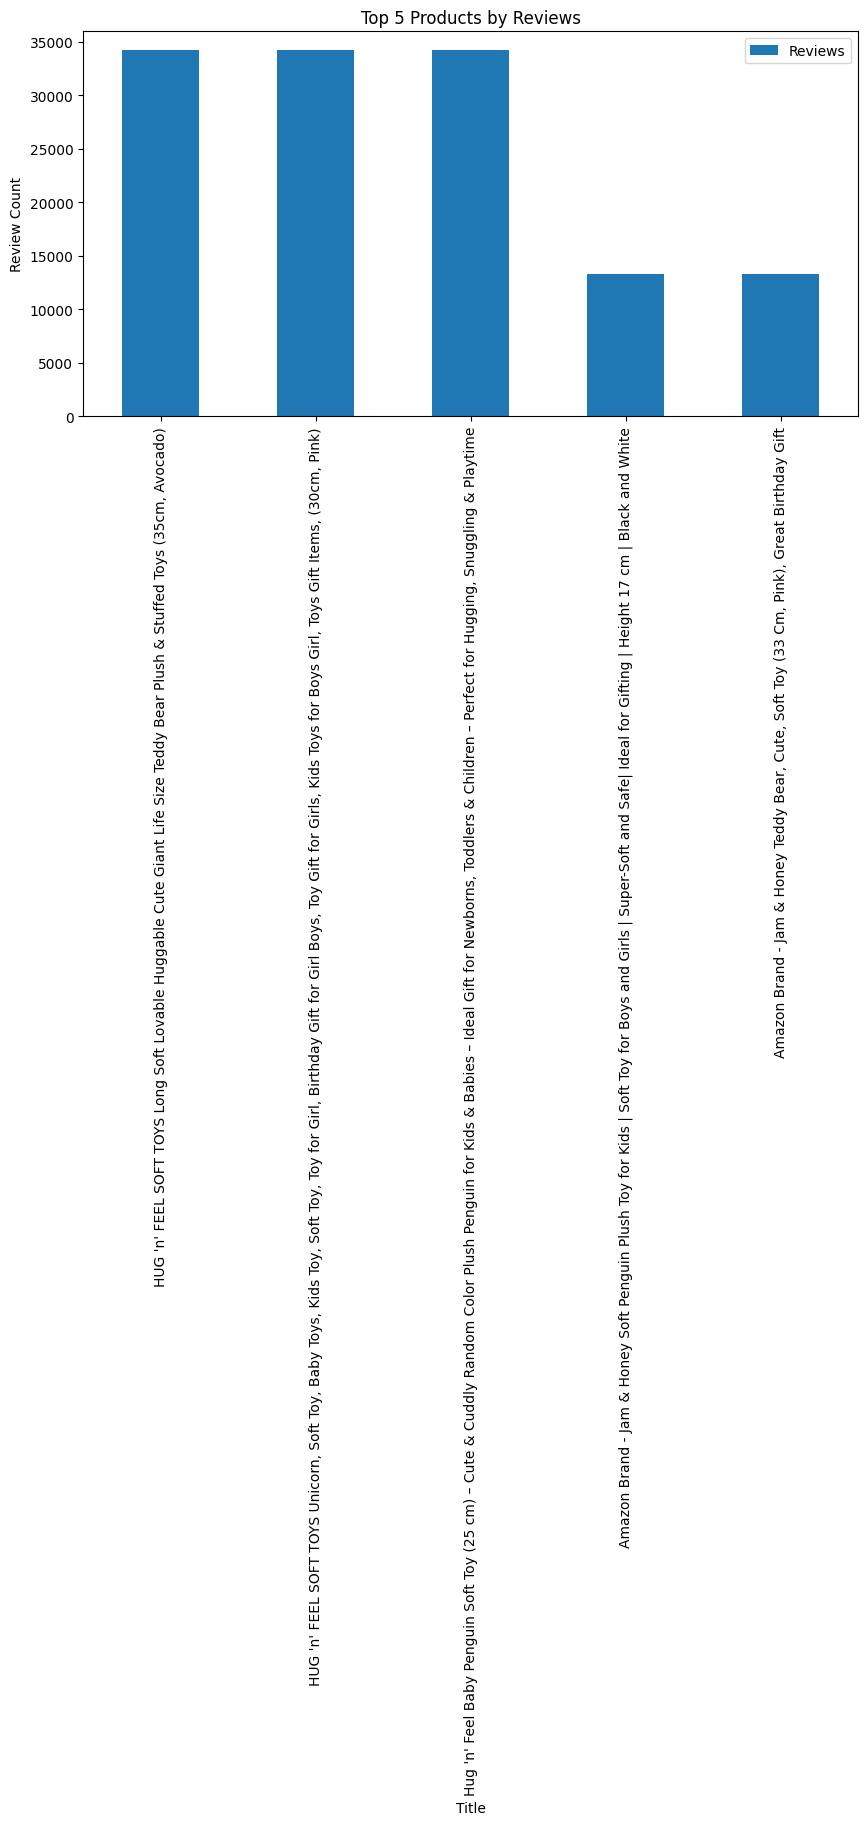

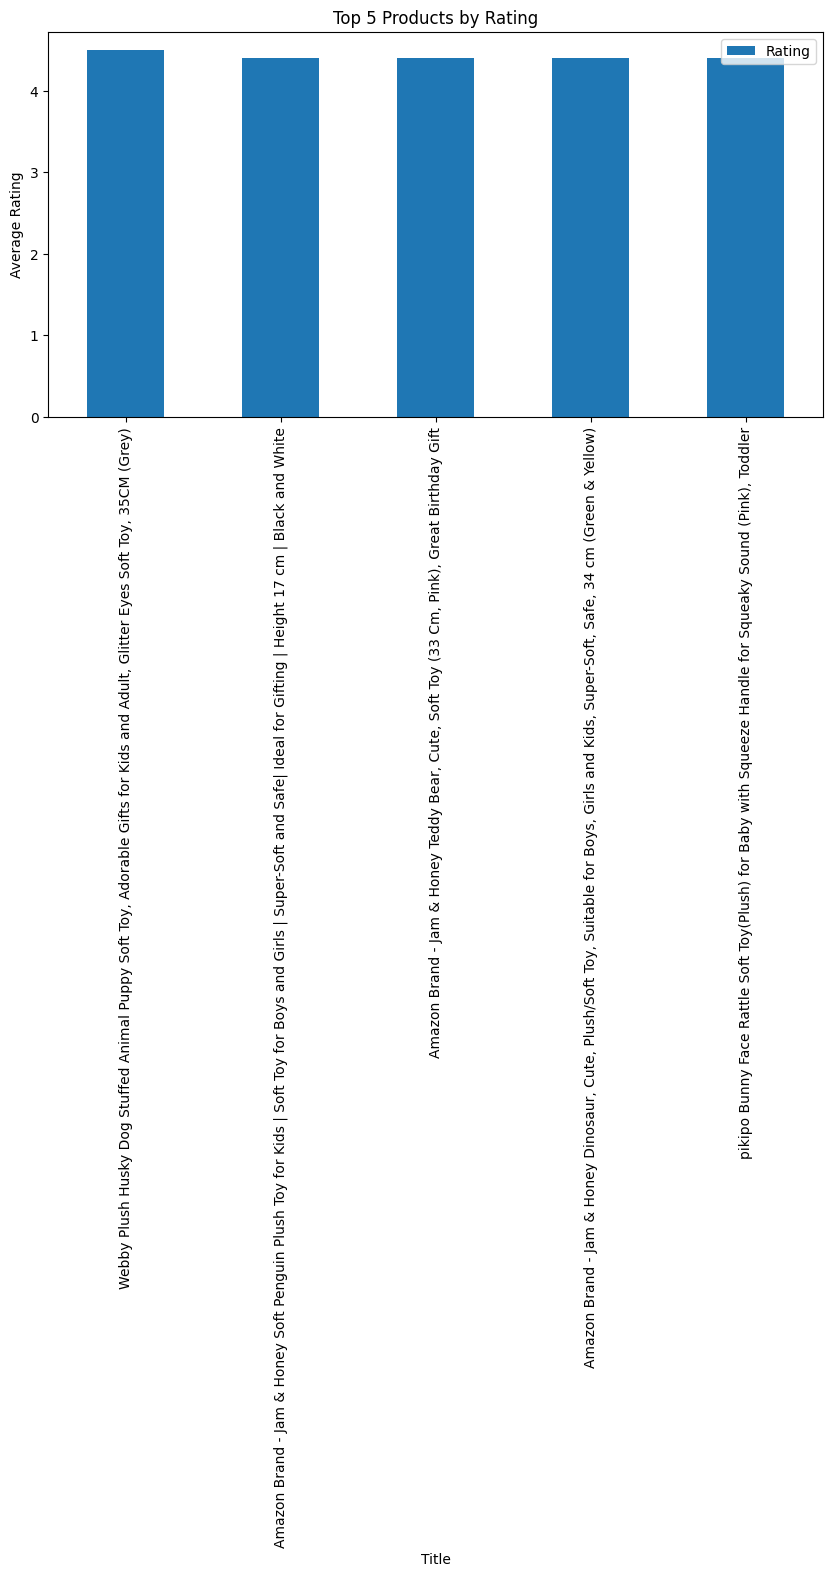

In [45]:
# Top 5 by Reviews
top_reviews = df.sort_values(by='Reviews', ascending=False).head(5)
top_reviews.plot.bar(x='Title', y='Reviews', title='Top 5 Products by Reviews', figsize=(10,5))
plt.ylabel("Review Count")
plt.show()

# Top 5 by Rating
top_rated = df.sort_values(by='Rating', ascending=False).head(5)
top_rated.plot.bar(x='Title', y='Rating', title='Top 5 Products by Rating', figsize=(10,5))
plt.ylabel("Average Rating")
plt.show()
